### compare direct embeddings to discrepancy embeddings
- first compute embeddings directly
- then compute embeddings with non-parametric umap
- then train a neural network to predict the non-parametric embeddings from input
- compute the loss for each embedding

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [6]:
import tensorflow as tf
visible_devices = tf.config.get_visible_devices()
for devices in visible_devices:
  print(devices)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset

In [7]:
from tensorflow.keras.datasets import mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### Compute nonparametric-umap

In [9]:
from umap import UMAP

In [10]:
embedder = UMAP(verbose=True)

In [11]:
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Jan 14 12:03:38 2021 Finding Nearest Neighbors
Thu Jan 14 12:03:38 2021 Building RP forest with 16 trees
Thu Jan 14 12:03:39 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Jan 14 12:03:54 2021 Finished Nearest Neighbor Search
Thu Jan 14 12:03:56 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jan 14 12:04:27 2021 Finished embedding


Text(0.5, 1.0, 'UMAP with UMAP-learn')

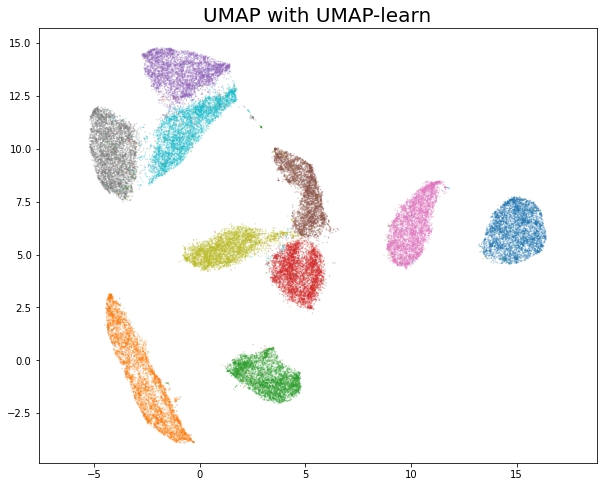

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(
    z_umap[:, 0],
    z_umap[:, 1],
    c=Y_train.astype(int)[:len(z_umap)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);

### train network

In [13]:
dims = (28*28,1)
n_components = 2
n_neurons = 5
activation = "relu"

In [14]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_neurons, activation=activation),
    tf.keras.layers.Dense(units=n_components),
])

In [15]:
encoder.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [16]:
encoder.fit(X_train_flat, z_umap, epochs=25)

Epoch 1/25
1563/1563 [==============================] - 3s 2ms/step - loss: 12.6506 - accuracy: 0.8106
Epoch 2/25
1563/1563 [==============================] - 3s 2ms/step - loss: 6.3248 - accuracy: 0.8731
Epoch 3/25
1563/1563 [==============================] - 3s 2ms/step - loss: 5.6403 - accuracy: 0.8718
Epoch 4/25
1563/1563 [==============================] - 3s 2ms/step - loss: 5.2841 - accuracy: 0.8703
Epoch 5/25
1563/1563 [==============================] - 3s 2ms/step - loss: 5.0834 - accuracy: 0.8685
Epoch 6/25
1563/1563 [==============================] - 3s 2ms/step - loss: 4.9403 - accuracy: 0.8677
Epoch 7/25
1563/1563 [==============================] - 3s 2ms/step - loss: 4.8094 - accuracy: 0.8684
Epoch 8/25
1563/1563 [==============================] - 3s 2ms/step - loss: 4.4006 - accuracy: 0.8750
Epoch 9/25
1563/1563 [==============================] - 4s 2ms/step - loss: 4.2335 - accuracy: 0.8783
Epoch 10/25
1563/1563 [==============================] - 3s 2ms/step - loss: 4.12

In [17]:
Z_umap_fit = encoder.predict(X_train_flat)

In [18]:
encoder.history.history

{}

Text(0.5, 1.0, 'UMAP with UMAP-learn')

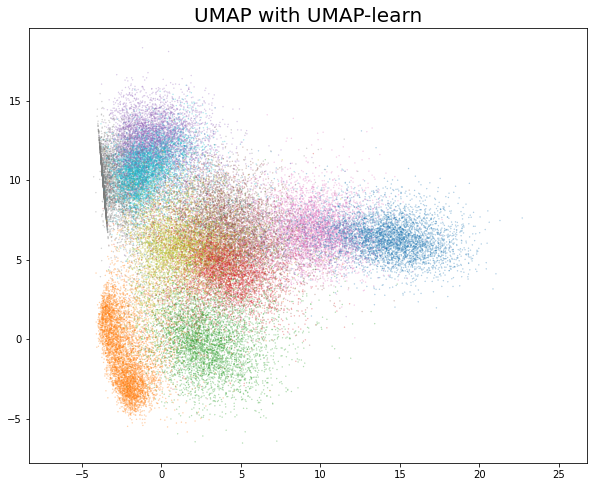

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(
    Z_umap_fit[:, 0],
    Z_umap_fit[:, 1],
    c=Y_train.astype(int)[:len(z_umap)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);

### save network output

In [27]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [28]:
output_dir = MODEL_DIR / 'constrained_projections'/ 'mnist' / 'network_discrepancy' / str(n_neurons)
ensure_dir(output_dir)

In [30]:
encoder.save(output_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TypeError: Expected binary or unicode string, got PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network_discrepancy/5')

In [33]:
np.save(output_dir / 'z.npy', Z_umap_fit)

### compute umap loss

In [34]:
from tfumap.umap import get_graph_elements
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
    embedder.graph_, embedder.n_epochs
)
max_sample_repeats_per_epoch = 25
batch_size = 1000
def batch_epoch_edges(edges_to, edges_from):
        """ permutes and batches edges for epoch
        """
        # compute the number of batches in one epoch
        n_batches = int(len(edges_to) / batch_size)
        # permute list of edges
        permutation_mask = np.random.permutation(len(edges_to))[
            : n_batches * batch_size
        ]
        to_all = tf.reshape(
            tf.gather(edges_to, permutation_mask), (n_batches, batch_size)
        )
        from_all = tf.reshape(
            tf.gather(edges_from, permutation_mask), (n_batches, batch_size)
        )
        # return a tensorflow dataset of one epoch's worth of batches
        return tf.data.Dataset.from_tensor_slices((to_all, from_all))
def create_edge_iterator(head, tail, weight):
        """ create an iterator for edges
        """
        # set the maximum number of times each edge should be repeated per epoch
        
        epochs_per_sample = np.clip(
            (weight / np.max(weight)) * max_sample_repeats_per_epoch,
            1,
            max_sample_repeats_per_epoch,
        ).astype("int")

        edges_to_exp, edges_from_exp = (
            np.array([np.repeat(head, epochs_per_sample.astype("int"))]),
            np.array([np.repeat(tail, epochs_per_sample.astype("int"))]),
        )
        edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
        edge_iter = edge_iter.repeat()
        edge_iter = edge_iter.map(batch_epoch_edges)
        edge_iter = edge_iter.prefetch(buffer_size=10)

        return iter(edge_iter), np.shape(edges_to_exp)[1]
    
from tfumap.umap import convert_distance_to_probability, compute_cross_entropy
def compute_umap_loss(z_umap, embedder, batch_to, batch_from):
        """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """

        # get the embeddings
        embedding_to = tf.gather(z_umap, batch_to)
        embedding_from = tf.gather(z_umap, batch_from)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, embedder.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, embedder.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, embedder._a, embedder._b
        )

        # treat positive samples as p=1, and negative samples as p=0
        probabilities_graph = tf.concat(
            [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])],
            axis=0,
        )

        # cross entropy loss
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=embedder.repulsion_strength,
        )

        return ce_loss, embedding_to, embedding_from

In [21]:
# create iterator for data/edges
edge_iter, n_edges_per_epoch = create_edge_iterator(head, tail, weight)

In [22]:
edge_epoch = next((iter(edge_iter)))

In [23]:
ce_loss_list = []
for batch_to, batch_from in tqdm(edge_epoch):
    (ce_loss, _, _) = compute_umap_loss(
                        Z_umap_fit, embedder, batch_to, batch_from
                    )
    ce_loss_list.append(np.mean(ce_loss.numpy()))

0it [00:00, ?it/s]

In [24]:
umap_learn_loss = np.mean(ce_loss_list)
umap_learn_loss

0.28298324

In [35]:
np.save(output_dir / 'umap_loss.npy', [np.mean(ce_loss_list), np.std(ce_loss_list)])